In [2]:
import json

# Try to find which line is causing the issue
print("Checking JSONL file for errors...")

errors = []
valid_lines = []

with open('attention_metrics.jsonl', 'r') as f:
    for line_num, line in enumerate(f, 1):
        try:
            obj = json.loads(line)
            valid_lines.append(obj)
        except json.JSONDecodeError as e:
            errors.append({
                'line': line_num,
                'error': str(e),
                'content': line[:200]  # First 200 chars
            })

print(f"\n{'='*80}")
print(f"DIAGNOSIS RESULTS")
print(f"{'='*80}")
print(f"Total lines: {line_num}")
print(f"Valid lines: {len(valid_lines)}")
print(f"Error lines: {len(errors)}")

if errors:
    print(f"\n⚠️ Found {len(errors)} problematic lines:")
    for err in errors[:5]:  # Show first 5 errors
        print(f"\nLine {err['line']}:")
        print(f"  Error: {err['error']}")
        print(f"  Content: {err['content'][:100]}...")

Checking JSONL file for errors...

DIAGNOSIS RESULTS
Total lines: 266
Valid lines: 266
Error lines: 0


In [3]:
import pandas as pd
import json

# Load the file line-by-line (this always works for JSONL)
def load_jsonl(filepath):
    """Load JSONL file into DataFrame"""
    records = []
    with open(filepath, 'r') as f:
        for line in f:
            if line.strip():  # Skip empty lines
                records.append(json.loads(line))
    return pd.DataFrame(records)

# Load your data
df = load_jsonl('attention_metrics.jsonl')

print("="*80)
print("DATA LOADED SUCCESSFULLY")
print("="*80)
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(df.head(3))

DATA LOADED SUCCESSFULLY
Shape: (266, 8)
Columns: ['id', 'dataset', 'constraint_tags', 'seq_len', 'p_len', 'u_len', 'a_len', 'layers']

First 3 rows:
             id dataset constraint_tags  seq_len  p_len  u_len  a_len  \
0  alpaca:22052  alpaca              []       22     19      1      1   
1  alpaca:24364  alpaca              []       20     17      1      1   
2     flan:1369    flan              []      312    309      1      1   

                                              layers  
0  [{'layer': 0, 'PAM': 0.6838161504788332, 'QAM'...  
1  [{'layer': 0, 'PAM': 0.6812704754115657, 'QAM'...  
2  [{'layer': 0, 'PAM': 0.8749497295166293, 'QAM'...  


In [5]:
import pandas as pd
import json

# Load the nested data
def load_jsonl(filepath):
    records = []
    with open(filepath, 'r') as f:
        for line in f:
            if line.strip():
                records.append(json.loads(line))
    return pd.DataFrame(records)

df_nested = load_jsonl('attention_metrics.jsonl')

print("="*80)
print("ORIGINAL NESTED DATA")
print("="*80)
print(f"Shape: {df_nested.shape}")
print(f"Columns: {df_nested.columns.tolist()}")

# Look at one example to understand structure
print("\nExample 'layers' field:")
print(df_nested.loc[0, 'layers'][0])  # First layer of first example

# ========================================
# UNNEST THE DATA
# ========================================

def unnest_layers(df):
    """Explode the nested 'layers' column into separate rows"""

    rows = []

    for idx, row in df.iterrows():
        # Get the base fields
        base_info = {
            'id': row['id'],
            'dataset': row['dataset'],
            'constraint_tags': row['constraint_tags'],
            'seq_len': row['seq_len'],
            'p_len': row['p_len'],
            'u_len': row['u_len'],
            'a_len': row['a_len']
        }

        # Explode each layer
        for layer_data in row['layers']:
            record = base_info.copy()
            record.update(layer_data)  # Add layer, PAM, QAM, SAM, head
            rows.append(record)

    return pd.DataFrame(rows)

# Unnest the data
df = unnest_layers(df_nested)

print("\n" + "="*80)
print("UNNESTED DATA")
print("="*80)
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())

# Verify PAM/QAM/SAM are now accessible
print("\n" + "="*80)
print("VERIFICATION")
print("="*80)
print("PAM column exists:", 'PAM' in df.columns)
print("QAM column exists:", 'QAM' in df.columns)
print("SAM column exists:", 'SAM' in df.columns)

if 'PAM' in df.columns:
    print(f"\nPAM stats:")
    print(f"  Mean: {df['PAM'].mean():.4f}")
    print(f"  Min:  {df['PAM'].min():.4f}")
    print(f"  Max:  {df['PAM'].max():.4f}")

ORIGINAL NESTED DATA
Shape: (266, 8)
Columns: ['id', 'dataset', 'constraint_tags', 'seq_len', 'p_len', 'u_len', 'a_len', 'layers']

Example 'layers' field:
{'layer': 0, 'PAM': 0.6838161504788332, 'QAM': 0.09756367398767907, 'SAM': 0.12260474392314791, 'heads': [{'head': 0, 'PAM': 0.5002431869506836, 'QAM': 0.16298165917396545, 'SAM': 0.15198931097984314}, {'head': 1, 'PAM': 0.0002248941600555554, 'QAM': 0.14286160469055176, 'SAM': 0.8524389863014221}, {'head': 2, 'PAM': 0.5554550290107727, 'QAM': 0.14663861691951752, 'SAM': 0.13089054822921753}, {'head': 3, 'PAM': 0.7453128099441528, 'QAM': 0.08623126149177551, 'SAM': 0.0899389386177063}, {'head': 4, 'PAM': 0.1423267275094986, 'QAM': 0.34588828682899475, 'SAM': 0.009316587820649147}, {'head': 5, 'PAM': 0.7184081673622131, 'QAM': 0.09277661144733429, 'SAM': 0.09983799606561661}, {'head': 6, 'PAM': 0.9020718336105347, 'QAM': 0.032831065356731415, 'SAM': 0.032264724373817444}, {'head': 7, 'PAM': 0.7081997394561768, 'QAM': 0.09755054861307

In [10]:
import pandas as pd
import json

# ========================================
# LOAD AND UNNEST WITH HEADS
# ========================================

def unnest_with_heads(df_nested):
    """Properly unnest layers AND heads"""

    rows = []

    for idx, row in df_nested.iterrows():
        base_info = {
            'id': row['id'],
            'dataset': row['dataset'],
            'constraint_tags': row['constraint_tags'],
            'seq_len': row['seq_len'],
            'p_len': row['p_len'],
            'u_len': row['u_len'],
            'a_len': row['a_len']
        }

        for layer_data in row['layers']:
            layer_num = layer_data['layer']

            # Get the heads array
            if 'heads' in layer_data:
                for head_data in layer_data['heads']:
                    record = base_info.copy()
                    record['layer'] = layer_num
                    record['head'] = head_data['head']
                    record['PAM'] = head_data['PAM']
                    record['QAM'] = head_data['QAM']
                    record['SAM'] = head_data['SAM']
                    rows.append(record)

    return pd.DataFrame(rows)

# Load nested data
def load_jsonl(filepath):
    records = []
    with open(filepath, 'r') as f:
        for line in f:
            if line.strip():
                records.append(json.loads(line))
    return pd.DataFrame(records)

df_nested = load_jsonl('attention_metrics.jsonl')

print("="*80)
print("UNNESTING DATA (WITH HEADS)")
print("="*80)

# Unnest properly
df = unnest_with_heads(df_nested)

print(f"\nOriginal shape (nested): {df_nested.shape}")
print(f"Unnested shape: {df.shape}")
print(f"Expected: {len(df_nested)} examples × 32 layers × 32 heads = {len(df_nested) * 32 * 32} rows")
print(f"Actual: {len(df)} rows")

print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 10 rows:")
print(df.head(10))

# Verify head column
print("\n" + "="*80)
print("VERIFICATION")
print("="*80)
print(f"✅ Head column exists: {'head' in df.columns}")
print(f"Number of unique layers: {df['layer'].nunique()}")
print(f"Number of unique heads: {df['head'].nunique()}")
print(f"Layer range: {df['layer'].min()}-{df['layer'].max()}")
print(f"Head range: {df['head'].min()}-{df['head'].max()}")

# Check normalization
df['sum_check'] = df['PAM'] + df['QAM'] + df['SAM']
print(f"\nPAM + QAM + SAM check:")
print(f"  Mean: {df['sum_check'].mean():.6f}")
print(f"  Min:  {df['sum_check'].min():.6f}")
print(f"  Max:  {df['sum_check'].max():.6f}")

if abs(df['sum_check'].mean() - 1.0) < 0.01:
    print("  ✅ Normalization correct (sum ≈ 1.0)")

UNNESTING DATA (WITH HEADS)

Original shape (nested): (266, 8)
Unnested shape: (272384, 12)
Expected: 266 examples × 32 layers × 32 heads = 272384 rows
Actual: 272384 rows

Columns: ['id', 'dataset', 'constraint_tags', 'seq_len', 'p_len', 'u_len', 'a_len', 'layer', 'head', 'PAM', 'QAM', 'SAM']

First 10 rows:
             id dataset constraint_tags  seq_len  p_len  u_len  a_len  layer  \
0  alpaca:22052  alpaca              []       22     19      1      1      0   
1  alpaca:22052  alpaca              []       22     19      1      1      0   
2  alpaca:22052  alpaca              []       22     19      1      1      0   
3  alpaca:22052  alpaca              []       22     19      1      1      0   
4  alpaca:22052  alpaca              []       22     19      1      1      0   
5  alpaca:22052  alpaca              []       22     19      1      1      0   
6  alpaca:22052  alpaca              []       22     19      1      1      0   
7  alpaca:22052  alpaca              []       22 


SUMMARY STATISTICS BY DATASET

DATASET: ALPACA

PAM:
count    102400.000000
mean          0.824223
std           0.204682
min           0.000007
25%           0.768721
50%           0.905786
75%           0.963514
max           0.999953
Name: PAM, dtype: float64
Skewness: -1.826
Kurtosis: 2.976

QAM:
count    102400.000000
mean          0.112184
std           0.161794
min           0.000003
25%           0.016349
50%           0.048195
75%           0.130351
max           0.998366
Name: QAM, dtype: float64
Skewness: 2.524
Kurtosis: 6.833

SAM:
count    102400.000000
mean          0.038226
std           0.072013
min           0.000008
25%           0.004991
50%           0.013768
75%           0.039188
max           0.953212
Name: SAM, dtype: float64
Skewness: 5.010
Kurtosis: 36.282

PAM + QAM + SAM:
  Mean: 0.974633
  Std:  0.048946
  ⚠️ Warning: Sum != 1.0 (mean = 0.975)

DATASET: FLAN

PAM:
count    102400.000000
mean          0.905958
std           0.138245
min           0.000341
2

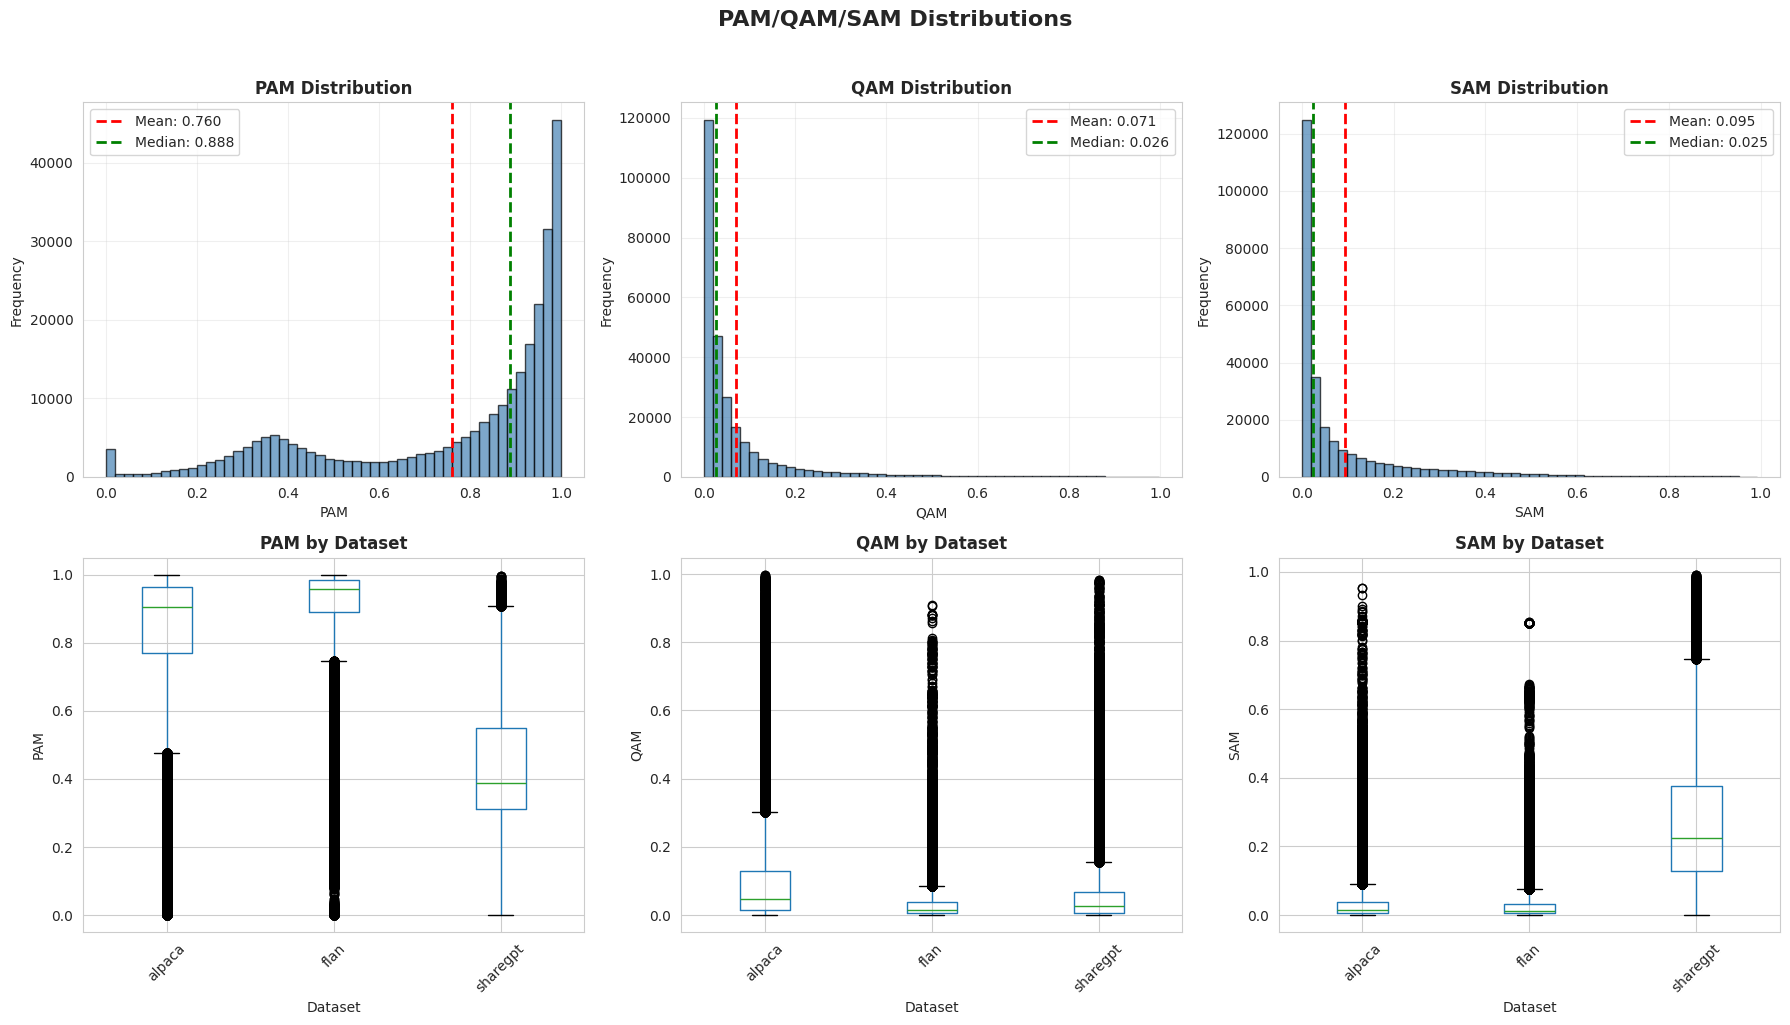


LAYER-WISE ATTENTION PATTERNS
💾 Saved: layer_wise_attention.png


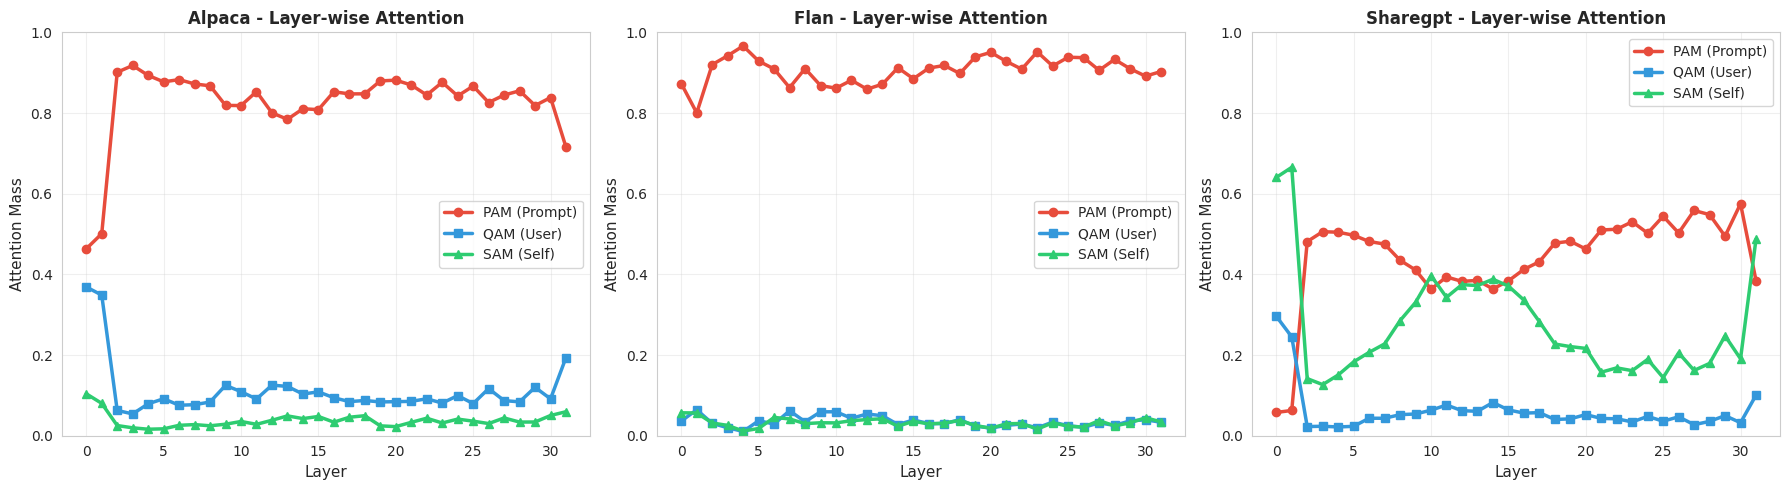


ALPACA:
  Highest PAM: Layer 3 (0.918)
  Highest QAM: Layer 0 (0.369)
  Highest SAM: Layer 0 (0.104)
  Early layers (0-10):
    PAM: 0.801, QAM: 0.134, SAM: 0.037
  Late layers (20-31):
    PAM: 0.836, QAM: 0.103, SAM: 0.040

FLAN:
  Highest PAM: Layer 4 (0.966)
  Highest QAM: Layer 1 (0.064)
  Highest SAM: Layer 0 (0.057)
  Early layers (0-10):
    PAM: 0.895, QAM: 0.040, SAM: 0.035
  Late layers (20-31):
    PAM: 0.920, QAM: 0.029, SAM: 0.030

SHAREGPT:
  Highest PAM: Layer 30 (0.575)
  Highest QAM: Layer 0 (0.296)
  Highest SAM: Layer 1 (0.665)
  Early layers (0-10):
    PAM: 0.389, QAM: 0.081, SAM: 0.305
  Late layers (20-31):
    PAM: 0.515, QAM: 0.045, SAM: 0.208

ATTENTION HEAD SPECIALIZATION

Prompt-specialist heads (PAM > 0.6): 911
User-specialist heads (QAM > 0.6): 1
Self-specialist heads (SAM > 0.6): 1

Top 5 Prompt-specialist heads:
  Layer 30, Head 13: PAM=0.948, QAM=0.004, SAM=0.009
  Layer 30, Head 17: PAM=0.915, QAM=0.005, SAM=0.018
  Layer 30, Head 20: PAM=0.911, QAM=

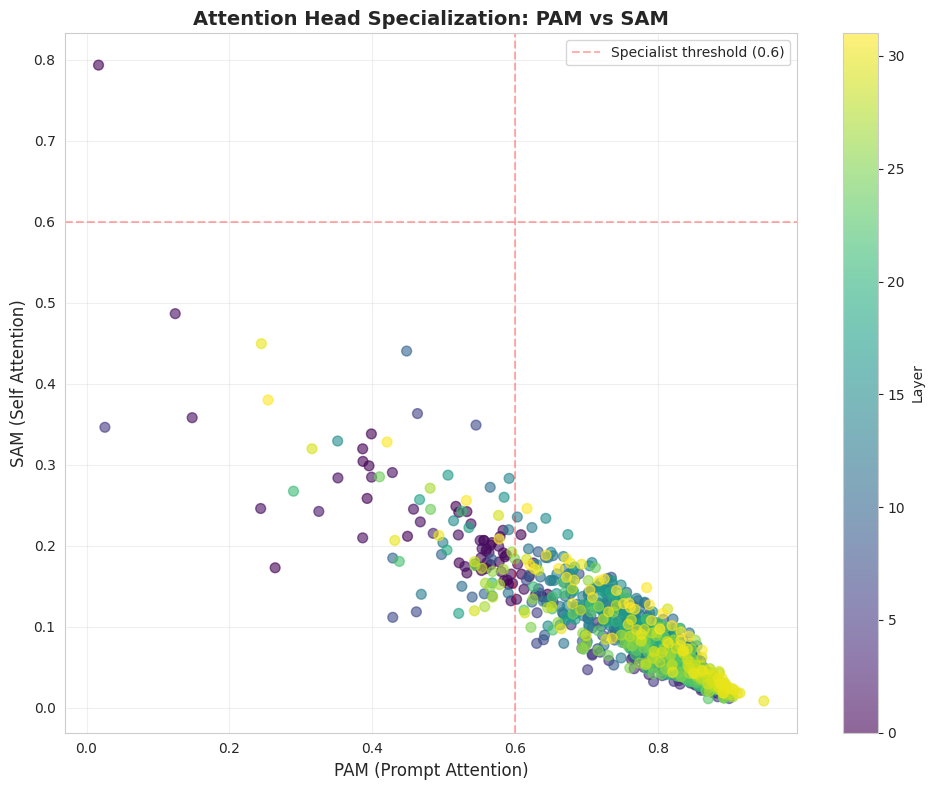


DATASET COMPARISON

PAM:
  F-statistic: 556.743
  p-value: 0.0000
  ✅ SIGNIFICANT difference across datasets
  Means:
    alpaca    : 0.824 ± 0.060
    flan      : 0.906 ± 0.005
    sharegpt  : 0.441 ± 0.168

QAM:
  F-statistic: 61.096
  p-value: 0.0000
  ✅ SIGNIFICANT difference across datasets
  Means:
    alpaca    : 0.112 ± 0.069
    flan      : 0.035 ± 0.002
    sharegpt  : 0.062 ± 0.054

SAM:
  F-statistic: 1998.418
  p-value: 0.0000
  ✅ SIGNIFICANT difference across datasets
  Means:
    alpaca    : 0.038 ± 0.004
    flan      : 0.032 ± 0.002
    sharegpt  : 0.274 ± 0.053

💾 Saved: dataset_comparison.png


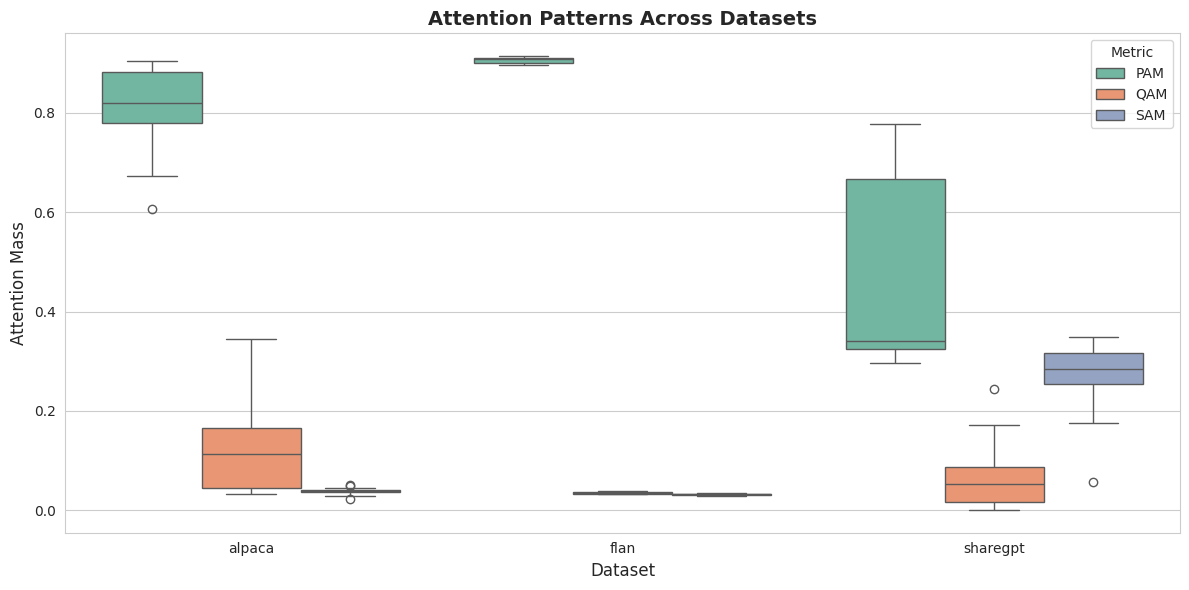


CORRELATION MATRIX BY DATASET

ALPACA - Correlations with PAM/QAM/SAM:
              PAM       QAM       SAM
PAM      1.000000 -0.889515 -0.598556
QAM     -0.889515  1.000000  0.244518
SAM     -0.598556  0.244518  1.000000
layer    0.108257 -0.112436 -0.004477
head     0.012361  0.002647 -0.027141
p_len    0.086774 -0.112249 -0.011179
u_len   -0.222679  0.320057 -0.018237
a_len         NaN       NaN       NaN
seq_len -0.212276  0.307332 -0.020649

FLAN - Correlations with PAM/QAM/SAM:
              PAM       QAM       SAM
PAM      1.000000 -0.906929 -0.857382
QAM     -0.906929  1.000000  0.670693
SAM     -0.857382  0.670693  1.000000
layer    0.080319 -0.066512 -0.041920
head     0.023291 -0.009263 -0.027355
p_len    0.007148 -0.006742 -0.006677
u_len         NaN       NaN       NaN
a_len         NaN       NaN       NaN
seq_len  0.007148 -0.006742 -0.006677

SHAREGPT - Correlations with PAM/QAM/SAM:
              PAM       QAM       SAM
PAM      1.000000 -0.502092 -0.528927
QAM     -0

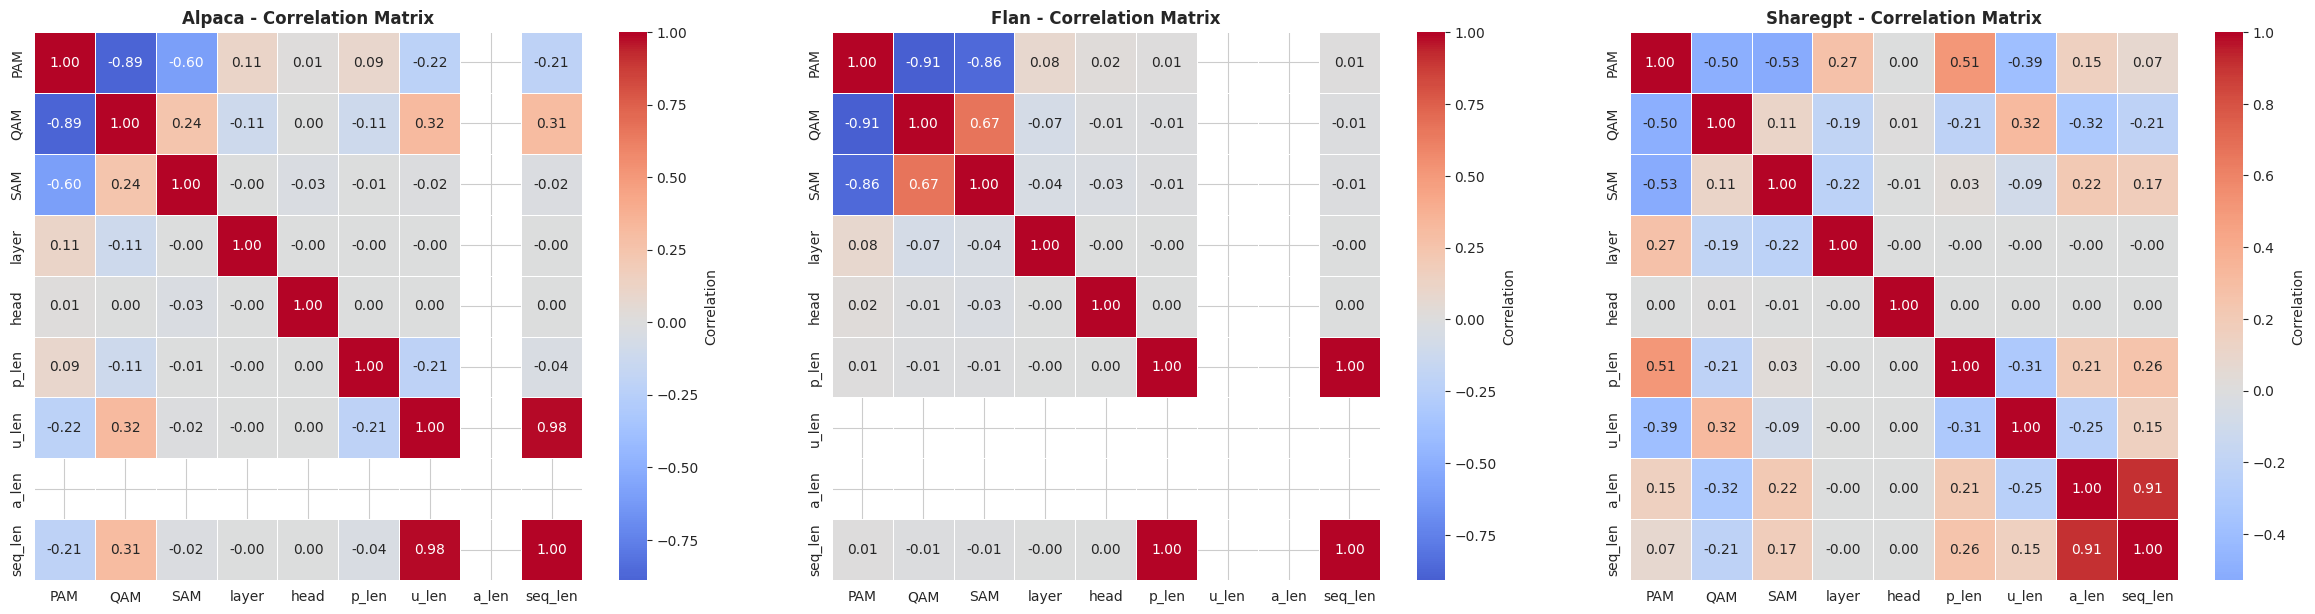


ATTENTION vs SEGMENT LENGTH BY DATASET

DATASET: ALPACA

PAM vs p_len:
  N (valid examples): 100
  Correlation: 0.298
  p-value: 0.0026
  ✅ SIGNIFICANT: Longer p_len → Higher PAM
  Segment length stats:
    Min: 9, Max: 75
    Mean: 19.3, Median: 17.5

QAM vs u_len:
  N (valid examples): 100
  Correlation: 0.757
  p-value: 0.0000
  ✅ SIGNIFICANT: Longer u_len → Higher QAM
  Segment length stats:
    Min: 1, Max: 330
    Mean: 25.1, Median: 9.5

SAM vs a_len:
  N (valid examples): 100
  Correlation: nan
  p-value: nan
  ❌ Not significant
  Segment length stats:
    Min: 1, Max: 1
    Mean: 1.0, Median: 1.0

DATASET: FLAN

PAM vs p_len:
  N (valid examples): 100
  Correlation: 0.205
  p-value: 0.0408
  ✅ SIGNIFICANT: Longer p_len → Higher PAM
  Segment length stats:
    Min: 140, Max: 746
    Mean: 273.7, Median: 276.0

QAM vs u_len:
  N (valid examples): 100
  Correlation: nan
  p-value: nan
  ❌ Not significant
  Segment length stats:
    Min: 1, Max: 1
    Mean: 1.0, Median: 1.0

SAM 

/tmp/ipython-input-2362347348.py:317: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val = stats.pearsonr(valid_data[segment], valid_data[metric])
/tmp/ipython-input-2362347348.py:363: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(valid_data[segment], valid_data[metric], 1)



💾 Saved: attention_vs_length_alpaca.png


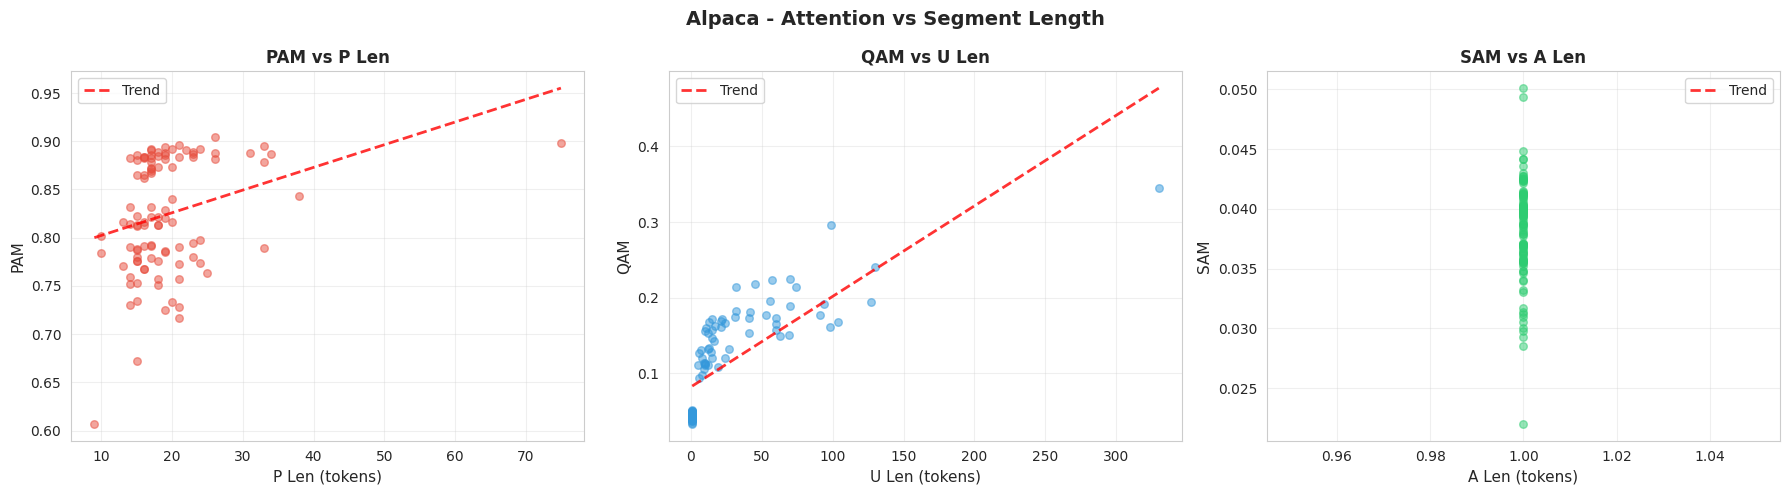

/tmp/ipython-input-2362347348.py:363: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(valid_data[segment], valid_data[metric], 1)
/tmp/ipython-input-2362347348.py:363: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(valid_data[segment], valid_data[metric], 1)



💾 Saved: attention_vs_length_flan.png


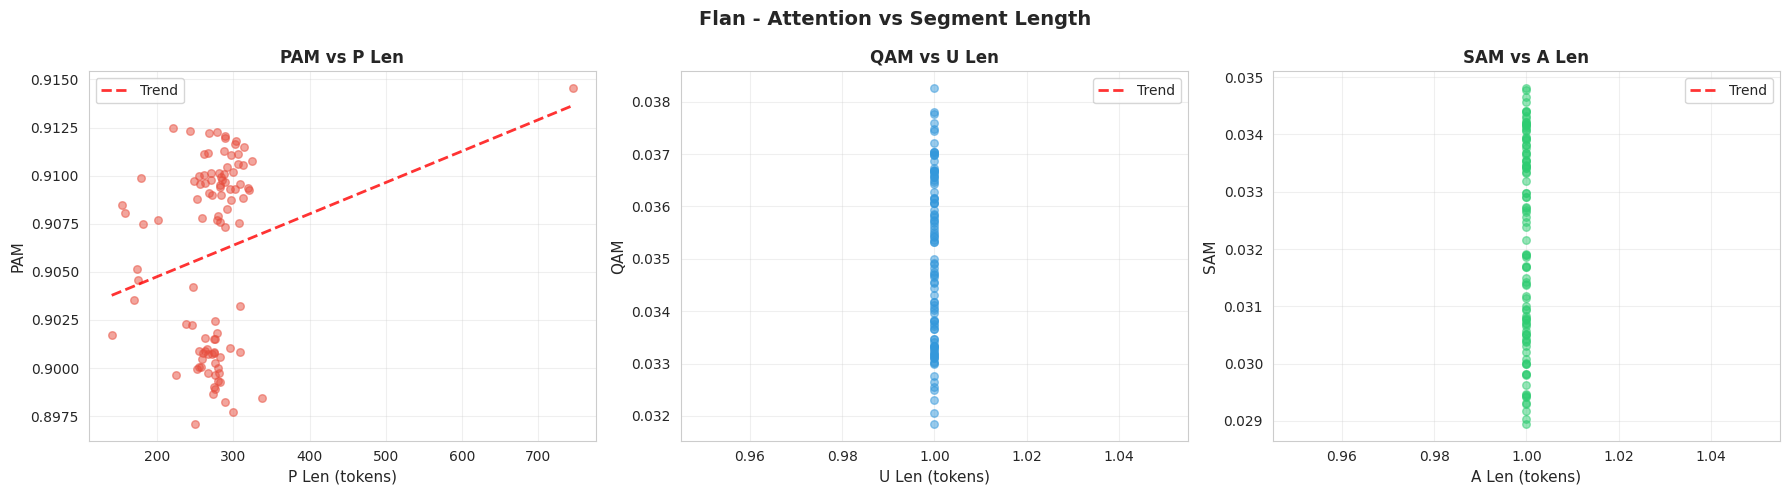


💾 Saved: attention_vs_length_sharegpt.png


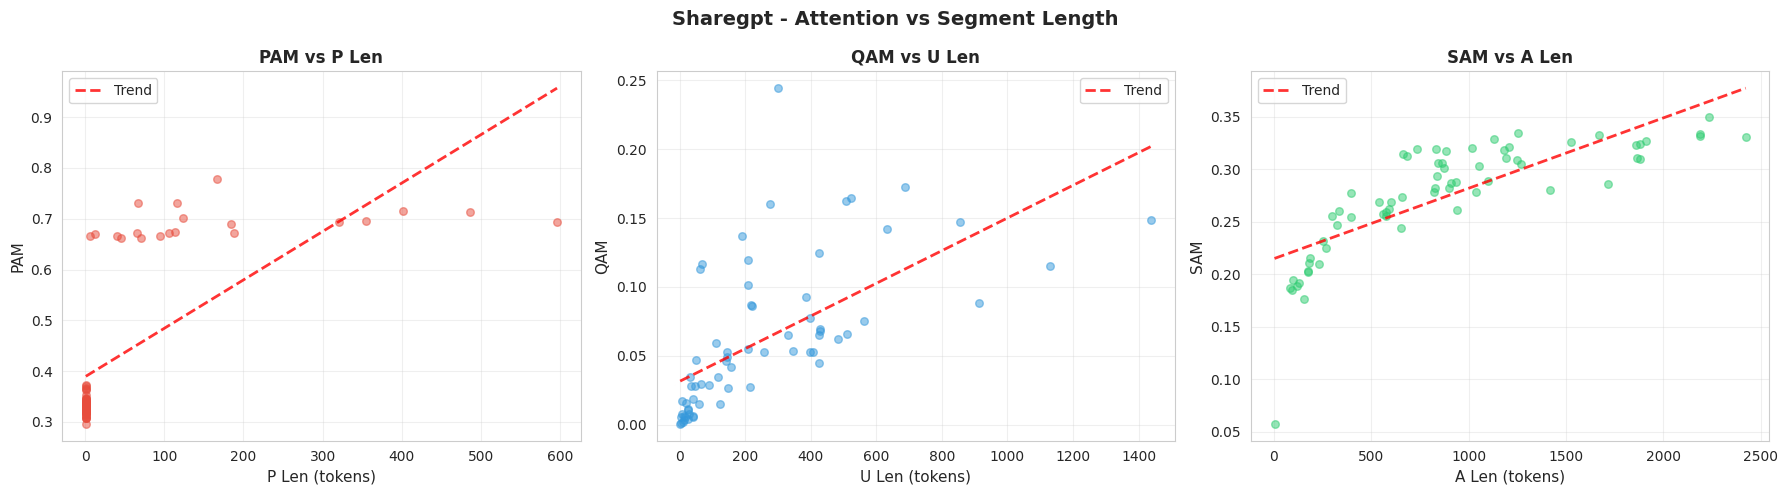


✅ COMPREHENSIVE EDA COMPLETE!

Generated visualizations:
  • eda_distributions.png
  • layer_wise_attention.png
  • head_specialization.png
  • dataset_comparison.png
  • correlation_matrix_by_dataset.png
  • attention_vs_length_alpaca.png
  • attention_vs_length_flan.png
  • attention_vs_length_sharegpt.png

💾 Saved flattened data: attention_metrics_flat.csv
💾 Saved example-level data: attention_metrics_example_level.csv

FINAL SUMMARY BY DATASET

ALPACA:
  Total data points: 102400
  Unique examples: 100
  Layers analyzed: 0-31
  Heads per layer: 32
  Segment length summary:
    P (prompt): mean=19.3, max=75
    U (user):   mean=25.1, max=330
    A (assist): mean=1.0, max=1
  Attention summary:
    PAM: mean=0.824, std=0.205
    QAM: mean=0.112, std=0.162
    SAM: mean=0.038, std=0.072

FLAN:
  Total data points: 102400
  Unique examples: 100
  Layers analyzed: 0-31
  Heads per layer: 32
  Segment length summary:
    P (prompt): mean=273.7, max=746
    U (user):   mean=1.0, max=1
  

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")

# ========================================
# 1. BASIC STATISTICS - BY DATASET
# ========================================

print("\n" + "="*80)
print("SUMMARY STATISTICS BY DATASET")
print("="*80)

for dataset in df['dataset'].unique():
    print(f"\n{'='*80}")
    print(f"DATASET: {dataset.upper()}")
    print(f"{'='*80}")

    dataset_df = df[df['dataset'] == dataset]

    for metric in ['PAM', 'QAM', 'SAM']:
        print(f"\n{metric}:")
        print(dataset_df[metric].describe())
        print(f"Skewness: {stats.skew(dataset_df[metric]):.3f}")
        print(f"Kurtosis: {stats.kurtosis(dataset_df[metric]):.3f}")

    # Check normalization per dataset
    dataset_df_copy = dataset_df.copy()
    dataset_df_copy['sum_check'] = dataset_df_copy['PAM'] + dataset_df_copy['QAM'] + dataset_df_copy['SAM']
    print(f"\nPAM + QAM + SAM:")
    print(f"  Mean: {dataset_df_copy['sum_check'].mean():.6f}")
    print(f"  Std:  {dataset_df_copy['sum_check'].std():.6f}")

    if abs(dataset_df_copy['sum_check'].mean() - 1.0) < 0.01:
        print("  ✅ Sum check passed (≈ 1.0)")
    else:
        print(f"  ⚠️ Warning: Sum != 1.0 (mean = {dataset_df_copy['sum_check'].mean():.3f})")

# Overall check
df['sum_check'] = df['PAM'] + df['QAM'] + df['SAM']
print(f"\n{'='*80}")
print("OVERALL (ALL DATASETS)")
print(f"{'='*80}")
print(f"\nPAM + QAM + SAM:")
print(f"  Mean: {df['sum_check'].mean():.6f}")
print(f"  Std:  {df['sum_check'].std():.6f}")

if abs(df['sum_check'].mean() - 1.0) < 0.01:
    print("  ✅ Sum check passed (≈ 1.0)")
else:
    print(f"  ⚠️ Warning: Sum != 1.0 (mean = {df['sum_check'].mean():.3f})")

# ========================================
# 2. DISTRIBUTION PLOTS
# ========================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, metric in enumerate(['PAM', 'QAM', 'SAM']):
    # Histogram
    ax1 = axes[0, idx]
    df[metric].hist(bins=50, ax=ax1, alpha=0.7, edgecolor='black', color='steelblue')
    ax1.set_title(f'{metric} Distribution', fontsize=12, fontweight='bold')
    ax1.set_xlabel(metric)
    ax1.set_ylabel('Frequency')
    ax1.axvline(df[metric].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df[metric].mean():.3f}')
    ax1.axvline(df[metric].median(), color='green', linestyle='--', linewidth=2,
                label=f'Median: {df[metric].median():.3f}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Box plot by dataset
    ax2 = axes[1, idx]
    df.boxplot(column=metric, by='dataset', ax=ax2)
    ax2.set_title(f'{metric} by Dataset', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Dataset')
    ax2.set_ylabel(metric)
    plt.sca(ax2)
    plt.xticks(rotation=45)

plt.suptitle('PAM/QAM/SAM Distributions', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('eda_distributions.png', dpi=150, bbox_inches='tight')
print("\n💾 Saved: eda_distributions.png")
plt.show()

# ========================================
# 3. LAYER-WISE ANALYSIS - FIXED QAM OUTPUT
# ========================================

print("\n" + "="*80)
print("LAYER-WISE ATTENTION PATTERNS")
print("="*80)

# Aggregate by layer and dataset
layer_patterns = df.groupby(['layer', 'dataset'])[['PAM', 'QAM', 'SAM']].mean().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = df['dataset'].unique()
for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    data = layer_patterns[layer_patterns['dataset'] == dataset]

    ax.plot(data['layer'], data['PAM'], marker='o', label='PAM (Prompt)',
            linewidth=2.5, markersize=6, color='#e74c3c')
    ax.plot(data['layer'], data['QAM'], marker='s', label='QAM (User)',
            linewidth=2.5, markersize=6, color='#3498db')
    ax.plot(data['layer'], data['SAM'], marker='^', label='SAM (Self)',
            linewidth=2.5, markersize=6, color='#2ecc71')

    ax.set_xlabel('Layer', fontsize=11)
    ax.set_ylabel('Attention Mass', fontsize=11)
    ax.set_title(f'{dataset.capitalize()} - Layer-wise Attention',
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('layer_wise_attention.png', dpi=150, bbox_inches='tight')
print("💾 Saved: layer_wise_attention.png")
plt.show()

# Print key findings - INCLUDING QAM
for dataset in datasets:
    print(f"\n{dataset.upper()}:")
    data = layer_patterns[layer_patterns['dataset'] == dataset]

    if len(data) > 0:
        max_pam_layer = data.loc[data['PAM'].idxmax(), 'layer']
        max_qam_layer = data.loc[data['QAM'].idxmax(), 'layer']
        max_sam_layer = data.loc[data['SAM'].idxmax(), 'layer']

        print(f"  Highest PAM: Layer {int(max_pam_layer)} ({data['PAM'].max():.3f})")
        print(f"  Highest QAM: Layer {int(max_qam_layer)} ({data['QAM'].max():.3f})")
        print(f"  Highest SAM: Layer {int(max_sam_layer)} ({data['SAM'].max():.3f})")

        # Early vs late layer patterns - INCLUDING QAM
        early_layers = data[data['layer'] <= data['layer'].max() / 3]
        late_layers = data[data['layer'] >= data['layer'].max() * 2/3]

        print(f"  Early layers (0-{int(data['layer'].max()/3)}):")
        print(f"    PAM: {early_layers['PAM'].mean():.3f}, QAM: {early_layers['QAM'].mean():.3f}, SAM: {early_layers['SAM'].mean():.3f}")
        print(f"  Late layers ({int(data['layer'].max()*2/3)}-{int(data['layer'].max())}):")
        print(f"    PAM: {late_layers['PAM'].mean():.3f}, QAM: {late_layers['QAM'].mean():.3f}, SAM: {late_layers['SAM'].mean():.3f}")

# ========================================
# 4. HEAD SPECIALIZATION
# ========================================

print("\n" + "="*80)
print("ATTENTION HEAD SPECIALIZATION")
print("="*80)

# Check if 'head' column exists
if 'head' in df.columns:
    head_patterns = df.groupby(['layer', 'head'])[['PAM', 'QAM', 'SAM']].mean()

    # Find specialist heads
    prompt_heads = head_patterns[head_patterns['PAM'] > 0.6]
    user_heads = head_patterns[head_patterns['QAM'] > 0.6]
    self_heads = head_patterns[head_patterns['SAM'] > 0.6]

    print(f"\nPrompt-specialist heads (PAM > 0.6): {len(prompt_heads)}")
    print(f"User-specialist heads (QAM > 0.6): {len(user_heads)}")
    print(f"Self-specialist heads (SAM > 0.6): {len(self_heads)}")

    if len(prompt_heads) > 0:
        print(f"\nTop 5 Prompt-specialist heads:")
        top_prompt = prompt_heads.nlargest(5, 'PAM')
        for (layer, head), row in top_prompt.iterrows():
            print(f"  Layer {layer}, Head {head}: PAM={row['PAM']:.3f}, QAM={row['QAM']:.3f}, SAM={row['SAM']:.3f}")

    # Visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter_data = head_patterns.reset_index()

    scatter = ax.scatter(scatter_data['PAM'], scatter_data['SAM'],
                         c=scatter_data['layer'], s=50, alpha=0.6, cmap='viridis')
    ax.set_xlabel('PAM (Prompt Attention)', fontsize=12)
    ax.set_ylabel('SAM (Self Attention)', fontsize=12)
    ax.set_title('Attention Head Specialization: PAM vs SAM', fontsize=14, fontweight='bold')
    ax.axhline(0.6, color='red', linestyle='--', alpha=0.3, label='Specialist threshold (0.6)')
    ax.axvline(0.6, color='red', linestyle='--', alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Layer')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('head_specialization.png', dpi=150, bbox_inches='tight')
    print("\n💾 Saved: head_specialization.png")
    plt.show()
else:
    print("⚠️ No 'head' column found - skipping head analysis")

# ========================================
# 5. DATASET COMPARISON (ANOVA)
# ========================================

print("\n" + "="*80)
print("DATASET COMPARISON")
print("="*80)

# Aggregate to example level
example_level = df.groupby(['id', 'dataset'])[['PAM', 'QAM', 'SAM']].mean().reset_index()

for metric in ['PAM', 'QAM', 'SAM']:
    print(f"\n{metric}:")

    # Get groups
    groups = [example_level[example_level['dataset'] == ds][metric] for ds in datasets]

    # ANOVA
    f_stat, p_val = stats.f_oneway(*groups)
    print(f"  F-statistic: {f_stat:.3f}")
    print(f"  p-value: {p_val:.4f}")

    if p_val < 0.05:
        print(f"  ✅ SIGNIFICANT difference across datasets")
    else:
        print(f"  ❌ No significant difference")

    # Means by dataset
    print(f"  Means:")
    for ds in datasets:
        mean_val = example_level[example_level['dataset'] == ds][metric].mean()
        std_val = example_level[example_level['dataset'] == ds][metric].std()
        print(f"    {ds:10s}: {mean_val:.3f} ± {std_val:.3f}")

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
df_melted = example_level.melt(id_vars=['dataset'], value_vars=['PAM', 'QAM', 'SAM'],
                                var_name='Metric', value_name='Value')
sns.boxplot(data=df_melted, x='dataset', y='Value', hue='Metric', ax=ax, palette='Set2')
ax.set_title('Attention Patterns Across Datasets', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Attention Mass', fontsize=12)
plt.tight_layout()
plt.savefig('dataset_comparison.png', dpi=150, bbox_inches='tight')
print("\n💾 Saved: dataset_comparison.png")
plt.show()

# ========================================
# 6. CORRELATION ANALYSIS - BY DATASET
# ========================================

print("\n" + "="*80)
print("CORRELATION MATRIX BY DATASET")
print("="*80)

# Select numeric columns for correlation
numeric_cols = ['PAM', 'QAM', 'SAM', 'layer']
if 'head' in df.columns:
    numeric_cols.append('head')
numeric_cols.extend(['p_len', 'u_len', 'a_len', 'seq_len'])

# Create correlation matrices for each dataset
n_datasets = len(datasets)
fig, axes = plt.subplots(1, n_datasets, figsize=(8*n_datasets, 6))
if n_datasets == 1:
    axes = [axes]

for idx, dataset in enumerate(datasets):
    dataset_df = df[df['dataset'] == dataset]
    corr_matrix = dataset_df[numeric_cols].corr()

    print(f"\n{dataset.upper()} - Correlations with PAM/QAM/SAM:")
    print(corr_matrix[['PAM', 'QAM', 'SAM']])

    ax = axes[idx]
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, ax=ax, cbar_kws={'label': 'Correlation'},
                linewidths=0.5)
    ax.set_title(f'{dataset.capitalize()} - Correlation Matrix',
                 fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('correlation_matrix_by_dataset.png', dpi=150, bbox_inches='tight')
print("\n💾 Saved: correlation_matrix_by_dataset.png")
plt.show()

# ========================================
# 7. ATTENTION vs SEGMENT LENGTH - BY DATASET
# ========================================

print("\n" + "="*80)
print("ATTENTION vs SEGMENT LENGTH BY DATASET")
print("="*80)

# Need to include segment lengths in the aggregation
example_level_with_lengths = df.groupby(['id', 'dataset']).agg({
    'PAM': 'mean',
    'QAM': 'mean',
    'SAM': 'mean',
    'p_len': 'first',
    'u_len': 'first',
    'a_len': 'first',
    'seq_len': 'first'
}).reset_index()

# Analyze correlations BY DATASET
for dataset in datasets:
    print(f"\n{'='*80}")
    print(f"DATASET: {dataset.upper()}")
    print(f"{'='*80}")

    dataset_df = example_level_with_lengths[example_level_with_lengths['dataset'] == dataset]

    for metric, segment in [('PAM', 'p_len'), ('QAM', 'u_len'), ('SAM', 'a_len')]:
        # Filter out zero-length segments
        valid_data = dataset_df[dataset_df[segment] > 0].copy()

        if len(valid_data) > 10:
            corr, p_val = stats.pearsonr(valid_data[segment], valid_data[metric])
            print(f"\n{metric} vs {segment}:")
            print(f"  N (valid examples): {len(valid_data)}")
            print(f"  Correlation: {corr:.3f}")
            print(f"  p-value: {p_val:.4f}")

            if p_val < 0.05:
                if corr > 0:
                    print(f"  ✅ SIGNIFICANT: Longer {segment} → Higher {metric}")
                else:
                    print(f"  ✅ SIGNIFICANT: Longer {segment} → Lower {metric}")
            else:
                print(f"  ❌ Not significant")

            print(f"  Segment length stats:")
            print(f"    Min: {valid_data[segment].min()}, Max: {valid_data[segment].max()}")
            print(f"    Mean: {valid_data[segment].mean():.1f}, Median: {valid_data[segment].median():.1f}")
        else:
            print(f"\n{metric} vs {segment}:")
            print(f"  ⚠️ Not enough data (only {len(valid_data)} examples with {segment} > 0)")

# ========================================
# 8. SCATTER PLOTS: Attention vs Length BY DATASET
# ========================================

for dataset in datasets:
    dataset_df = example_level_with_lengths[example_level_with_lengths['dataset'] == dataset]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (metric, segment, color) in enumerate([
        ('PAM', 'p_len', '#e74c3c'),
        ('QAM', 'u_len', '#3498db'),
        ('SAM', 'a_len', '#2ecc71')
    ]):
        ax = axes[idx]

        # Filter valid data
        valid_data = dataset_df[dataset_df[segment] > 0]

        if len(valid_data) > 0:
            ax.scatter(valid_data[segment], valid_data[metric],
                       alpha=0.5, s=30, color=color)

            # Add trend line
            if len(valid_data) > 10:
                z = np.polyfit(valid_data[segment], valid_data[metric], 1)
                p = np.poly1d(z)
                x_line = np.linspace(valid_data[segment].min(), valid_data[segment].max(), 100)
                ax.plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.8, label='Trend')

            ax.set_xlabel(f'{segment.replace("_", " ").title()} (tokens)', fontsize=11)
            ax.set_ylabel(metric, fontsize=11)
            ax.set_title(f'{metric} vs {segment.replace("_", " ").title()}',
                         fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend()
        else:
            ax.text(0.5, 0.5, f'No data\n({segment} always 0)',
                    ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{metric} vs {segment.replace("_", " ").title()}',
                         fontsize=12, fontweight='bold')

    plt.suptitle(f'{dataset.capitalize()} - Attention vs Segment Length',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'attention_vs_length_{dataset}.png', dpi=150, bbox_inches='tight')
    print(f"\n💾 Saved: attention_vs_length_{dataset}.png")
    plt.show()

print("\n" + "="*80)
print("✅ COMPREHENSIVE EDA COMPLETE!")
print("="*80)
print("\nGenerated visualizations:")
print("  • eda_distributions.png")
print("  • layer_wise_attention.png")
print("  • head_specialization.png")
print("  • dataset_comparison.png")
print("  • correlation_matrix_by_dataset.png")
for dataset in datasets:
    print(f"  • attention_vs_length_{dataset}.png")

# Save the complete unnested dataframe
df.to_csv('attention_metrics_flat.csv', index=False)
print("\n💾 Saved flattened data: attention_metrics_flat.csv")

# Save example-level aggregated data
example_level_with_lengths.to_csv('attention_metrics_example_level.csv', index=False)
print("💾 Saved example-level data: attention_metrics_example_level.csv")

# ========================================
# FINAL SUMMARY STATISTICS - BY DATASET
# ========================================

print("\n" + "="*80)
print("FINAL SUMMARY BY DATASET")
print("="*80)

for dataset in datasets:
    dataset_df = df[df['dataset'] == dataset]
    print(f"\n{dataset.upper()}:")
    print(f"  Total data points: {len(dataset_df)}")
    print(f"  Unique examples: {dataset_df['id'].nunique()}")
    print(f"  Layers analyzed: {dataset_df['layer'].min()}-{dataset_df['layer'].max()}")

    if 'head' in dataset_df.columns:
        print(f"  Heads per layer: {dataset_df['head'].nunique()}")

    print(f"  Segment length summary:")
    print(f"    P (prompt): mean={dataset_df['p_len'].mean():.1f}, max={dataset_df['p_len'].max()}")
    print(f"    U (user):   mean={dataset_df['u_len'].mean():.1f}, max={dataset_df['u_len'].max()}")
    print(f"    A (assist): mean={dataset_df['a_len'].mean():.1f}, max={dataset_df['a_len'].max()}")

    print(f"  Attention summary:")
    for metric in ['PAM', 'QAM', 'SAM']:
        print(f"    {metric}: mean={dataset_df[metric].mean():.3f}, std={dataset_df[metric].std():.3f}")

print("\n🎉 Analysis complete! Ready for next steps:")
print("  → Behavior linking (instruction following)")
print("  → Hallucination detection")
print("  → Predictive modeling")

In [12]:
import pandas as pd
import numpy as np

# Load your data
df = pd.read_csv('attention_metrics_flat.csv')  # The unnested data

print("="*80)
print("CHECKING AVAILABLE DATA FOR BEHAVIOR ANALYSIS")
print("="*80)

print(f"\nColumns in dataset:")
print(df.columns.tolist())

print(f"\nUnique examples: {df['id'].nunique()}")
print(f"Datasets: {df['dataset'].unique()}")

# Check constraint tags
print(f"\nConstraint tags sample:")
sample_constraints = df.groupby('id')['constraint_tags'].first().head(10)
for idx, tags in sample_constraints.items():
    print(f"  {idx}: {tags}")

print(f"\nDo you have:")
print(f"  • Actual model outputs (assistant_generated text)? [Need for behavior scoring]")
print(f"  • Human labels (instruction_followed: 0/1)? [Need for validation]")
print(f"  • Hallucination labels? [Need for hallucination detection]")

CHECKING AVAILABLE DATA FOR BEHAVIOR ANALYSIS

Columns in dataset:
['id', 'dataset', 'constraint_tags', 'seq_len', 'p_len', 'u_len', 'a_len', 'layer', 'head', 'PAM', 'QAM', 'SAM', 'sum_check']

Unique examples: 266
Datasets: ['alpaca' 'flan' 'sharegpt']

Constraint tags sample:
  alpaca:10165: []
  alpaca:10236: []
  alpaca:1043: []
  alpaca:10592: []
  alpaca:10669: []
  alpaca:10710: []
  alpaca:11104: []
  alpaca:11123: []
  alpaca:11127: []
  alpaca:11546: []

Do you have:
  • Actual model outputs (assistant_generated text)? [Need for behavior scoring]
  • Human labels (instruction_followed: 0/1)? [Need for validation]
  • Hallucination labels? [Need for hallucination detection]


PROXY BEHAVIOR ANALYSIS

Total examples: 266
Datasets: ['alpaca' 'flan' 'sharegpt']

📊 HYPOTHESIS 1: High PAM = Better Instruction Following

OVERALL proxy instruction-following distribution:
proxy_following
1    209
0     57
Name: count, dtype: int64
Overall success rate: 78.6%

BY DATASET:

ALPACA:
  Success rate: 100.0% (100/100)
  Mean PAM: 0.824
  Mean QAM: 0.112
  Mean SAM: 0.038

FLAN:
  Success rate: 100.0% (100/100)
  Mean PAM: 0.906
  Mean QAM: 0.035
  Mean SAM: 0.032

SHAREGPT:
  Success rate: 13.6% (9/66)
  Mean PAM: 0.441
  Mean QAM: 0.062
  Mean SAM: 0.274

BY CONSTRAINT TYPE:

LENGTH_LIMIT:
  Overall: 92.4% success, PAM=0.791 (n=92)
    alpaca    : 100.0% success, PAM=0.821 (n=83)
    flan      : 100.0% success, PAM=0.915 (n=1)
    sharegpt  : 12.5% success, PAM=0.473 (n=8)

FORMAT_JSON:
  Overall: 66.7% success, PAM=0.717 (n=6)
    alpaca    : 100.0% success, PAM=0.778 (n=2)
    sharegpt  : 50.0% success, PAM=0.687 (n=4)

NO_EXPLANATIONS:
  Overall: 82.6% success, PAM=0

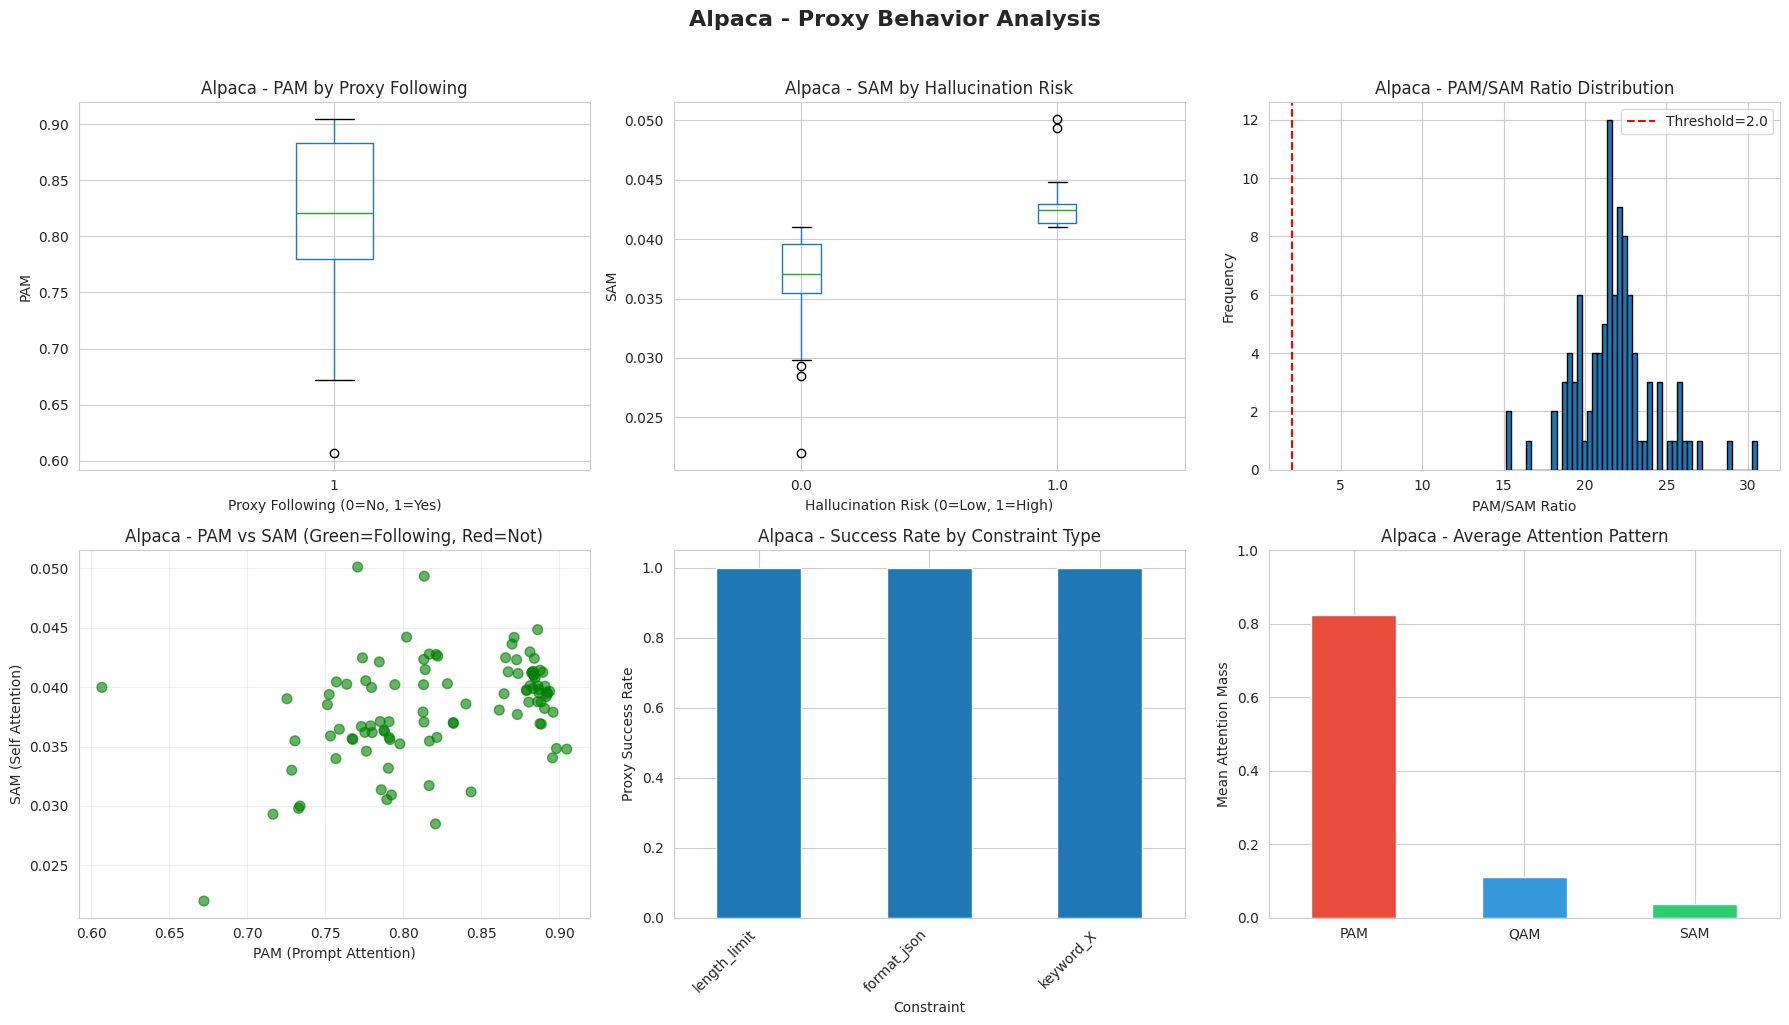


💾 Saved: proxy_behavior_analysis_flan.png


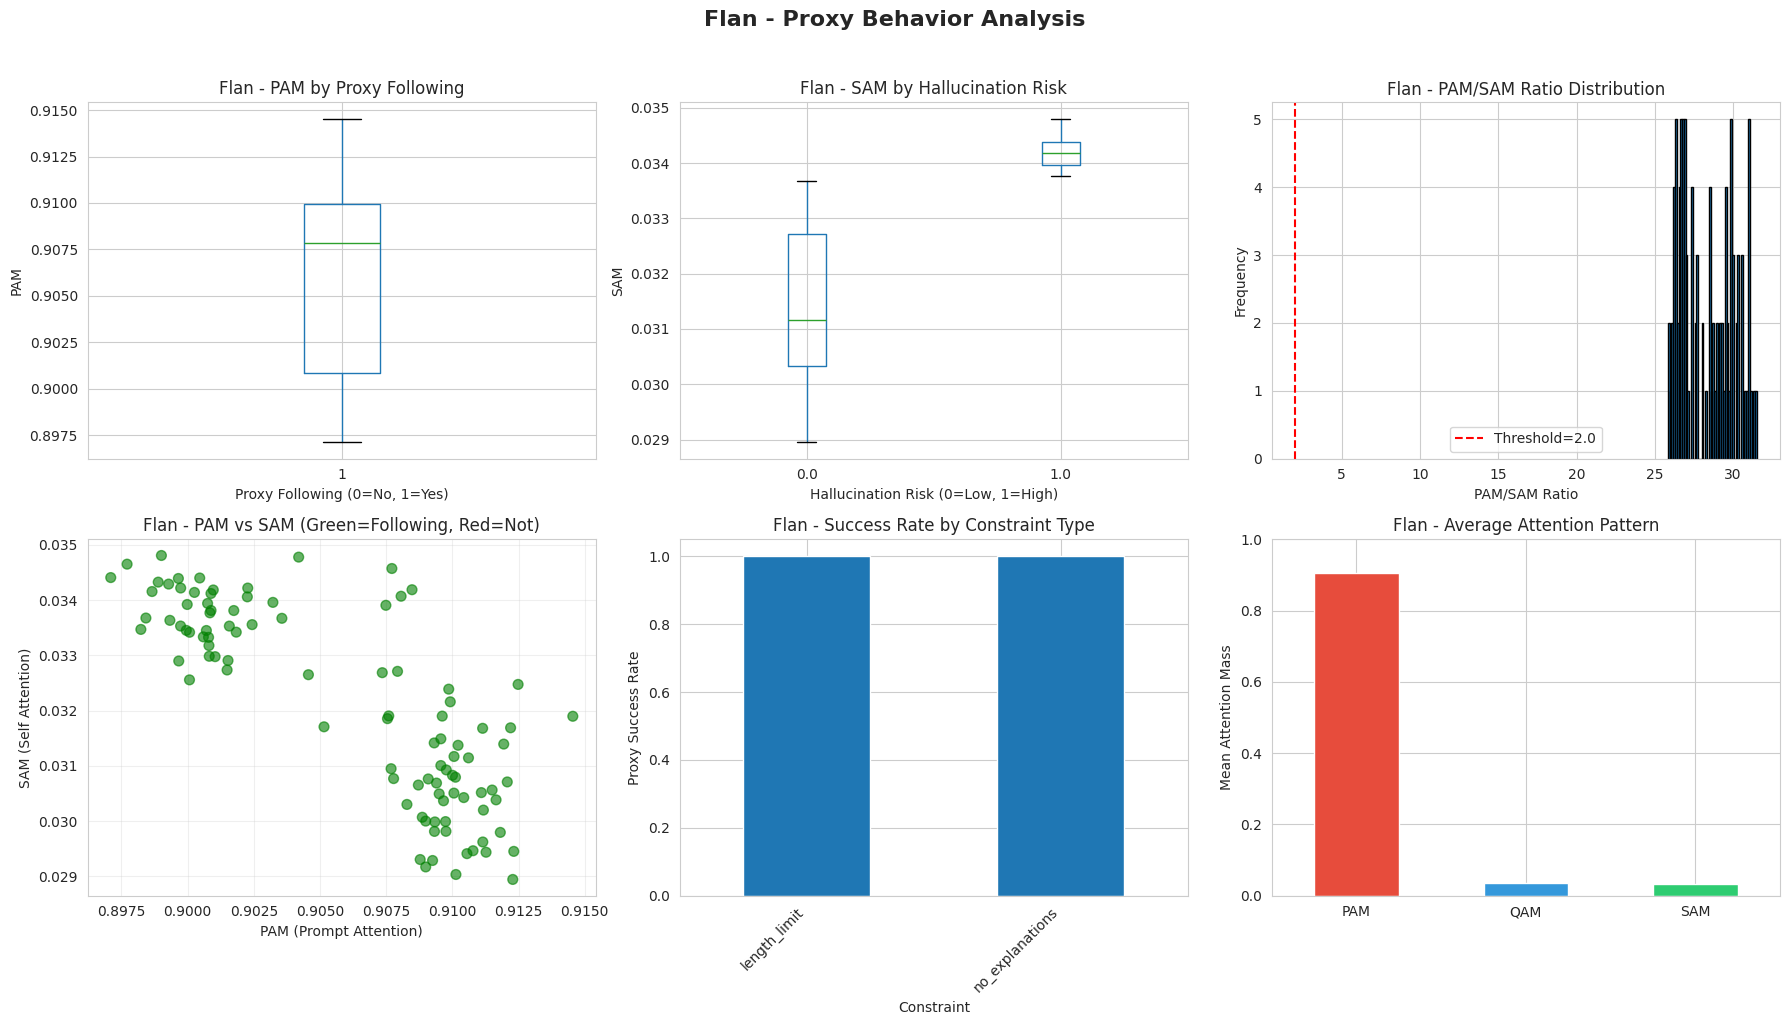


💾 Saved: proxy_behavior_analysis_sharegpt.png


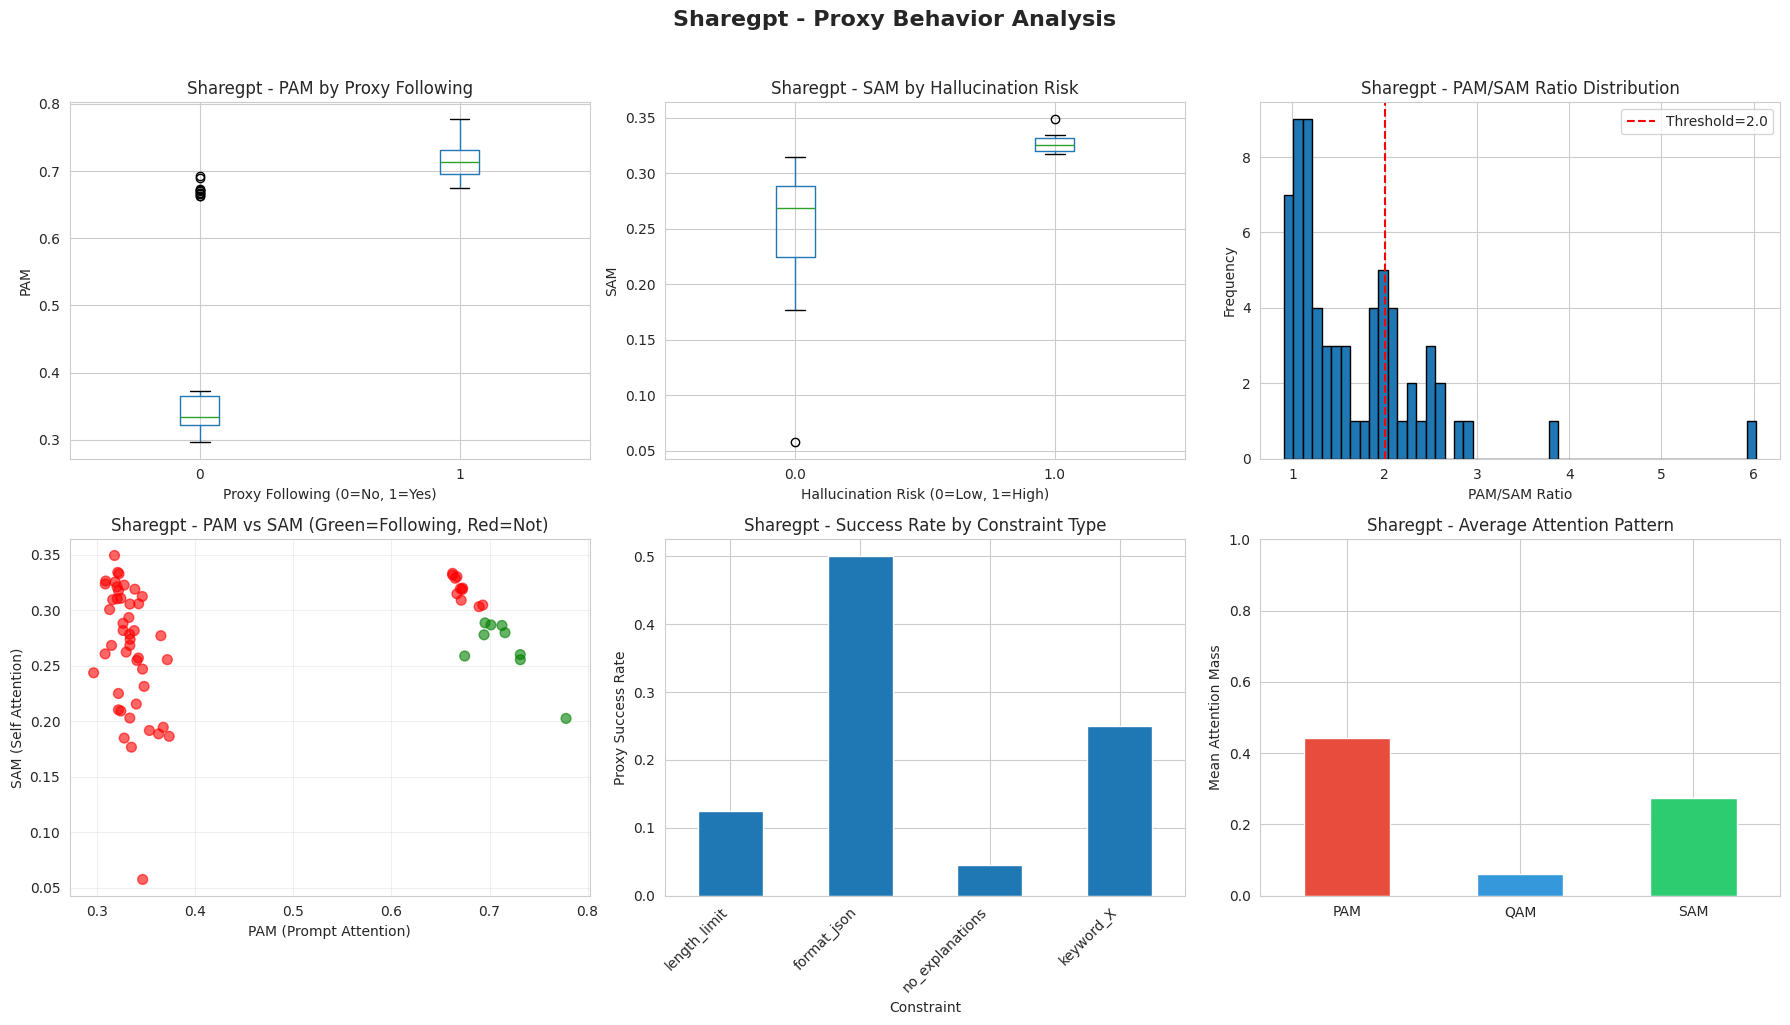


💾 Saved: proxy_behavior_cross_dataset.png


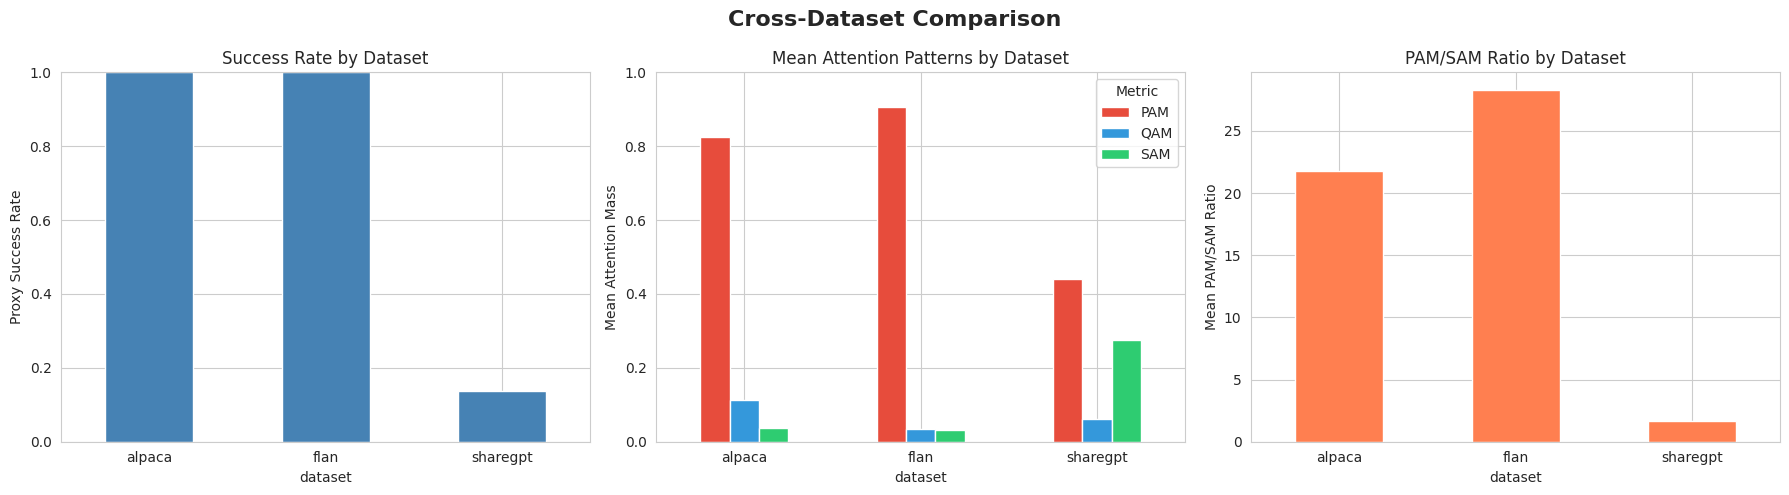


💾 Saved: proxy_behavior_results.csv

SUMMARY BY DATASET

ALPACA:
  N examples: 100
  Proxy following rate: 100.0%
  Mean PAM: 0.824 ± 0.060
  Mean QAM: 0.112 ± 0.069
  Mean SAM: 0.038 ± 0.004
  Mean PAM/SAM ratio: 21.78

FLAN:
  N examples: 100
  Proxy following rate: 100.0%
  Mean PAM: 0.906 ± 0.005
  Mean QAM: 0.035 ± 0.002
  Mean SAM: 0.032 ± 0.002
  Mean PAM/SAM ratio: 28.30

SHAREGPT:
  N examples: 66
  Proxy following rate: 13.6%
  Mean PAM: 0.441 ± 0.168
  Mean QAM: 0.062 ± 0.054
  Mean SAM: 0.274 ± 0.053
  Mean PAM/SAM ratio: 1.69

✅ PROXY ANALYSIS COMPLETE!

Generated visualizations:
  • proxy_behavior_analysis_alpaca.png
  • proxy_behavior_analysis_flan.png
  • proxy_behavior_analysis_sharegpt.png
  • proxy_behavior_cross_dataset.png


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ========================================
# LOAD DATA
# ========================================

# Load flattened attention data (from previous steps)
df = pd.read_csv('attention_metrics_flat.csv')

# Aggregate to example level
example_level = df.groupby(['id', 'dataset']).agg({
    'PAM': 'mean',
    'QAM': 'mean',
    'SAM': 'mean',
    'p_len': 'first',
    'u_len': 'first',
    'a_len': 'first',
    'seq_len': 'first'
}).reset_index()

# Add constraint info
original_data = pd.read_json('shuffled.jsonl', lines=True)
example_level = example_level.merge(
    original_data[['id', 'constraint_tags']],
    on='id'
)

print("="*80)
print("PROXY BEHAVIOR ANALYSIS")
print("="*80)
print(f"\nTotal examples: {len(example_level)}")
print(f"Datasets: {example_level['dataset'].unique()}")

# ========================================
# HYPOTHESIS 1: PAM → Instruction Following
# ========================================

print("\n" + "="*80)
print("📊 HYPOTHESIS 1: High PAM = Better Instruction Following")
print("="*80)

# Define proxy label
# High PAM (>0.6) AND Low SAM (<0.3) = likely following instructions
example_level['proxy_following'] = (
    (example_level['PAM'] > 0.6) &
    (example_level['SAM'] < 0.3)
).astype(int)

print(f"\nOVERALL proxy instruction-following distribution:")
print(example_level['proxy_following'].value_counts())
print(f"Overall success rate: {example_level['proxy_following'].mean()*100:.1f}%")

# By dataset
print(f"\n{'='*80}")
print("BY DATASET:")
print(f"{'='*80}")
for dataset in example_level['dataset'].unique():
    subset = example_level[example_level['dataset'] == dataset]
    rate = subset['proxy_following'].mean()
    pam_mean = subset['PAM'].mean()
    qam_mean = subset['QAM'].mean()
    sam_mean = subset['SAM'].mean()
    print(f"\n{dataset.upper()}:")
    print(f"  Success rate: {rate*100:.1f}% ({subset['proxy_following'].sum()}/{len(subset)})")
    print(f"  Mean PAM: {pam_mean:.3f}")
    print(f"  Mean QAM: {qam_mean:.3f}")
    print(f"  Mean SAM: {sam_mean:.3f}")

# By constraint type (overall and by dataset)
print(f"\n{'='*80}")
print("BY CONSTRAINT TYPE:")
print(f"{'='*80}")

for tag in ['length_limit', 'format_json', 'no_explanations', 'keyword_X']:
    has_tag = example_level['constraint_tags'].apply(
        lambda x: tag in x if isinstance(x, list) else False
    )
    if has_tag.sum() > 0:
        print(f"\n{tag.upper()}:")
        subset = example_level[has_tag]
        overall_rate = subset['proxy_following'].mean()
        overall_pam = subset['PAM'].mean()
        print(f"  Overall: {overall_rate*100:.1f}% success, PAM={overall_pam:.3f} (n={has_tag.sum()})")

        # By dataset
        for dataset in example_level['dataset'].unique():
            dataset_subset = subset[subset['dataset'] == dataset]
            if len(dataset_subset) > 0:
                rate = dataset_subset['proxy_following'].mean()
                pam = dataset_subset['PAM'].mean()
                print(f"    {dataset:10s}: {rate*100:.1f}% success, PAM={pam:.3f} (n={len(dataset_subset)})")

# ========================================
# HYPOTHESIS 2: SAM → Hallucination Risk
# ========================================

print("\n" + "="*80)
print("📊 HYPOTHESIS 2: High SAM = Hallucination Risk")
print("="*80)

# Define high-risk threshold BY DATASET
for dataset in example_level['dataset'].unique():
    dataset_df = example_level[example_level['dataset'] == dataset]
    high_sam_threshold = dataset_df['SAM'].quantile(0.75)

    print(f"\n{dataset.upper()}:")
    print(f"  SAM threshold (75th percentile): {high_sam_threshold:.3f}")

    example_level.loc[example_level['dataset'] == dataset, 'hallucination_risk'] = (
        example_level.loc[example_level['dataset'] == dataset, 'SAM'] > high_sam_threshold
    ).astype(int)

    high_risk_count = example_level[(example_level['dataset'] == dataset) &
                                    (example_level['hallucination_risk'] == 1)]
    print(f"  High-risk examples: {len(high_risk_count)} ({len(high_risk_count)/len(dataset_df)*100:.1f}%)")

    # Characteristics
    high_risk = dataset_df[dataset_df['SAM'] > high_sam_threshold]
    low_risk = dataset_df[dataset_df['SAM'] <= high_sam_threshold]

    print(f"  High SAM vs Low SAM characteristics:")
    print(f"    PAM:    {high_risk['PAM'].mean():.3f} vs {low_risk['PAM'].mean():.3f}")
    print(f"    QAM:    {high_risk['QAM'].mean():.3f} vs {low_risk['QAM'].mean():.3f}")
    print(f"    a_len:  {high_risk['a_len'].mean():.0f} vs {low_risk['a_len'].mean():.0f} tokens")

    # Statistical test
    if len(high_risk) > 1 and len(low_risk) > 1:
        t_stat, p_val = stats.ttest_ind(high_risk['PAM'], low_risk['PAM'])
        print(f"  PAM difference significance: t={t_stat:.3f}, p={p_val:.4f}")
        if p_val < 0.05:
            print("    ✅ SIGNIFICANT: High-SAM examples have different PAM!")
        else:
            print("    ❌ Not significant")

# ========================================
# HYPOTHESIS 3: PAM/SAM Ratio BY DATASET
# ========================================

print("\n" + "="*80)
print("📊 HYPOTHESIS 3: PAM/SAM Ratio Predicts Behavior")
print("="*80)

example_level['pam_sam_ratio'] = example_level['PAM'] / (example_level['SAM'] + 1e-6)

print(f"\nOVERALL PAM/SAM ratio statistics:")
print(example_level['pam_sam_ratio'].describe())

for dataset in example_level['dataset'].unique():
    dataset_df = example_level[example_level['dataset'] == dataset]
    print(f"\n{dataset.upper()} PAM/SAM ratio statistics:")
    print(dataset_df['pam_sam_ratio'].describe())

# High ratio = prompt-focused, Low ratio = self-focused
example_level['ratio_category'] = pd.cut(
    example_level['pam_sam_ratio'],
    bins=[0, 2, 5, 100],
    labels=['Self-focused', 'Balanced', 'Prompt-focused']
)

print(f"\nOVERALL ratio categories:")
print(example_level['ratio_category'].value_counts())

print(f"\nBY DATASET:")
for dataset in example_level['dataset'].unique():
    dataset_df = example_level[example_level['dataset'] == dataset]
    print(f"\n{dataset.upper()}:")
    print(dataset_df['ratio_category'].value_counts())

# ========================================
# VISUALIZATIONS
# ========================================

datasets = example_level['dataset'].unique()
n_datasets = len(datasets)

# Create separate figures for each dataset
for dataset in datasets:
    dataset_df = example_level[example_level['dataset'] == dataset]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # 1. PAM distribution by proxy label
    ax = axes[0, 0]
    dataset_df.boxplot(column='PAM', by='proxy_following', ax=ax)
    ax.set_title(f'{dataset.capitalize()} - PAM by Proxy Following')
    ax.set_xlabel('Proxy Following (0=No, 1=Yes)')
    ax.set_ylabel('PAM')

    # 2. SAM distribution by hallucination risk
    ax = axes[0, 1]
    if 'hallucination_risk' in dataset_df.columns:
        dataset_df.boxplot(column='SAM', by='hallucination_risk', ax=ax)
        ax.set_title(f'{dataset.capitalize()} - SAM by Hallucination Risk')
        ax.set_xlabel('Hallucination Risk (0=Low, 1=High)')
        ax.set_ylabel('SAM')

    # 3. PAM/SAM ratio distribution
    ax = axes[0, 2]
    dataset_df['pam_sam_ratio'].hist(bins=50, ax=ax, edgecolor='black')
    ax.set_xlabel('PAM/SAM Ratio')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{dataset.capitalize()} - PAM/SAM Ratio Distribution')
    ax.axvline(2.0, color='red', linestyle='--', label='Threshold=2.0')
    ax.legend()

    # 4. Scatter: PAM vs SAM
    ax = axes[1, 0]
    colors = dataset_df['proxy_following'].map({0: 'red', 1: 'green'})
    ax.scatter(dataset_df['PAM'], dataset_df['SAM'],
               c=colors, alpha=0.6, s=50)
    ax.set_xlabel('PAM (Prompt Attention)')
    ax.set_ylabel('SAM (Self Attention)')
    ax.set_title(f'{dataset.capitalize()} - PAM vs SAM (Green=Following, Red=Not)')
    ax.grid(True, alpha=0.3)

    # 5. Success rate by constraint
    ax = axes[1, 1]
    constraint_success = []
    for tag in ['length_limit', 'format_json', 'no_explanations', 'keyword_X']:
        has_tag = dataset_df['constraint_tags'].apply(
            lambda x: tag in x if isinstance(x, list) else False
        )
        if has_tag.sum() > 0:
            rate = dataset_df[has_tag]['proxy_following'].mean()
            constraint_success.append({'Constraint': tag, 'Success Rate': rate})

    if constraint_success:
        df_plot = pd.DataFrame(constraint_success)
        df_plot.plot(kind='bar', x='Constraint', y='Success Rate', ax=ax, legend=False)
        ax.set_ylabel('Proxy Success Rate')
        ax.set_title(f'{dataset.capitalize()} - Success Rate by Constraint Type')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # 6. Attention pattern visualization
    ax = axes[1, 2]
    metrics_data = dataset_df[['PAM', 'QAM', 'SAM']].mean()
    metrics_data.plot(kind='bar', ax=ax, color=['#e74c3c', '#3498db', '#2ecc71'])
    ax.set_ylabel('Mean Attention Mass')
    ax.set_title(f'{dataset.capitalize()} - Average Attention Pattern')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_ylim([0, 1])

    plt.suptitle(f'{dataset.capitalize()} - Proxy Behavior Analysis',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f'proxy_behavior_analysis_{dataset}.png', dpi=150, bbox_inches='tight')
    print(f"\n💾 Saved: proxy_behavior_analysis_{dataset}.png")
    plt.show()

# Overall comparison across datasets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Success rate comparison
ax = axes[0]
dataset_stats = example_level.groupby('dataset')['proxy_following'].mean()
dataset_stats.plot(kind='bar', ax=ax, color='steelblue')
ax.set_ylabel('Proxy Success Rate')
ax.set_title('Success Rate by Dataset')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylim([0, 1])

# 2. Mean attention patterns
ax = axes[1]
attention_means = example_level.groupby('dataset')[['PAM', 'QAM', 'SAM']].mean()
attention_means.plot(kind='bar', ax=ax, color=['#e74c3c', '#3498db', '#2ecc71'])
ax.set_ylabel('Mean Attention Mass')
ax.set_title('Mean Attention Patterns by Dataset')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Metric')
ax.set_ylim([0, 1])

# 3. PAM/SAM ratio comparison
ax = axes[2]
ratio_means = example_level.groupby('dataset')['pam_sam_ratio'].mean()
ratio_means.plot(kind='bar', ax=ax, color='coral')
ax.set_ylabel('Mean PAM/SAM Ratio')
ax.set_title('PAM/SAM Ratio by Dataset')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.suptitle('Cross-Dataset Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('proxy_behavior_cross_dataset.png', dpi=150, bbox_inches='tight')
print("\n💾 Saved: proxy_behavior_cross_dataset.png")
plt.show()

# ========================================
# SAVE RESULTS
# ========================================

example_level.to_csv('proxy_behavior_results.csv', index=False)
print("\n💾 Saved: proxy_behavior_results.csv")

# Summary statistics by dataset
print("\n" + "="*80)
print("SUMMARY BY DATASET")
print("="*80)

for dataset in datasets:
    dataset_df = example_level[example_level['dataset'] == dataset]
    print(f"\n{dataset.upper()}:")
    print(f"  N examples: {len(dataset_df)}")
    print(f"  Proxy following rate: {dataset_df['proxy_following'].mean()*100:.1f}%")
    print(f"  Mean PAM: {dataset_df['PAM'].mean():.3f} ± {dataset_df['PAM'].std():.3f}")
    print(f"  Mean QAM: {dataset_df['QAM'].mean():.3f} ± {dataset_df['QAM'].std():.3f}")
    print(f"  Mean SAM: {dataset_df['SAM'].mean():.3f} ± {dataset_df['SAM'].std():.3f}")
    print(f"  Mean PAM/SAM ratio: {dataset_df['pam_sam_ratio'].mean():.2f}")

print("\n" + "="*80)
print("✅ PROXY ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated visualizations:")
for dataset in datasets:
    print(f"  • proxy_behavior_analysis_{dataset}.png")
print("  • proxy_behavior_cross_dataset.png")